In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import json
import base64
import time

client_id = os.getenv('SPOTIFY_CLIENT_ID')
client_secret = os.getenv('SPOTIFY_CLIENT_SECRET')

In [2]:
# Function to get an access token from Spotify
def get_spotify_token(client_id, client_secret):
    client_creds = f"{client_id}:{client_secret}"
    # client_creds_b64 = base64.b64encode(client_creds.encode()).decode()  # Ensure this is decoded back to string
    client_creds_b64 = "ZWUxYzg1OWZhMTgwNDIyMzhiODIwM2IxMWNlOTMzMjU6ZDUwMjgxOTM2OWJhNDVjYWExYWJlYWRmYjIxYTc3YWU="   # TODO

    url = 'https://accounts.spotify.com/api/token'
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Authorization': f'Basic {client_creds_b64}'
    }
    payload = {'grant_type': 'client_credentials'}

    response = requests.post(url, headers=headers, data=payload)
    if response.status_code != 200:
        print("Failed to fetch token:")
        print("Status Code:", response.status_code)
        print("Response:", response.text)
    else:
        print(response.json())
    return response.json().get('access_token')

token = get_spotify_token(client_id, client_secret)
token

{'access_token': 'BQBf5YVBlPHbK3ygvBW9G60fm4qFosfOhiFktNQGE_r-7GZbmaHqlbg-vpRg3YO-DXRIdTN98c3xK7WYwloE67P6x5wHtEHsD1I1YyvuIftZliGI49Y', 'token_type': 'Bearer', 'expires_in': 3600}


'BQBf5YVBlPHbK3ygvBW9G60fm4qFosfOhiFktNQGE_r-7GZbmaHqlbg-vpRg3YO-DXRIdTN98c3xK7WYwloE67P6x5wHtEHsD1I1YyvuIftZliGI49Y'

## Data Collection

Gathering information from various sources.

I am using the Spotify Million Playlist dataset and the Spotify Web API to get the following features every song - 

1. track_id
2. artist_name
3. track_name
4. album_name
5. acousticness
6. danceability
7. energy
8. instrumentalness
9. liveness
10. loudness
11. speechiness
12. tempo
13. valence

I am building a dataframe that will be used to further build and optimize the machine learning models.


In [3]:
def safe_request(url, headers, retries=5, backoff_factor=2):
    """ Helper function to handle requests with retry logic including backoff """
    for i in range(retries):
        try:
            response = requests.get(url, headers=headers, timeout=10)  # Adding a timeout
            response.raise_for_status()
            return response
        except requests.exceptions.HTTPError as e:
            if response.status_code == 429:
                retry_after = int(response.headers.get('retry-after', 60))
                print(f"Rate limit exceeded, retrying in {retry_after} seconds")
                time.sleep(retry_after)
            else:
                print(f"HTTPError occurred: {e}")
                if i == retries - 1:
                    raise
                time.sleep(backoff_factor * (2 ** i))
        except requests.exceptions.RequestException as e:
            print(f"RequestException occurred: {e}")
            if i == retries - 1:
                raise
            time.sleep(backoff_factor * (2 ** i))

In [4]:
def get_artist_genres(artist_ids, token):
    """ Fetch genres for a list of artist IDs from Spotify """
    artist_ids = ','.join(artist_ids)  # Convert list of artist IDs to a comma-separated string
    url = f"https://api.spotify.com/v1/artists?ids={artist_ids}"
    headers = {'Authorization': f'Bearer {token}'}
    response = safe_request(url, headers)
    artists_details = response.json()

    genres = []
    for artist in artists_details['artists']:
        if artist:
            genres.extend(artist.get('genres', []))
    return list(set(genres))  # Return unique genres


def fetch_track_data(spotify_token, track_ids):
    headers = {'Authorization': f'Bearer {spotify_token}'}
    track_url = f"https://api.spotify.com/v1/tracks?ids={','.join(track_ids)}"
    features_url = f"https://api.spotify.com/v1/audio-features?ids={','.join(track_ids)}"

    track_response = safe_request(track_url, headers)
    features_response = safe_request(features_url, headers)

    track_details = track_response.json()
    features_details = features_response.json()

    track_data = []
    for i, track in enumerate(track_details['tracks']):
        if track and features_details['audio_features'][i]:
            artist_ids = [artist['id'] for artist in track['artists']]
            genres = get_artist_genres(artist_ids, spotify_token)
            feature = features_details['audio_features'][i]
            track_data.append({
                'track_id': track['id'],
                'artist_name': track['artists'][0]['name'],
                'track_name': track['name'],
                'album_name': track['album']['name'],
                'genres': genres,
                'acousticness': feature.get('acousticness', 0),
                'danceability': feature.get('danceability', 0),
                'energy': feature.get('energy', 0),
                'instrumentalness': feature.get('instrumentalness', 0),
                'liveness': feature.get('liveness', 0),
                'loudness': feature.get('loudness', 0),
                'speechiness': feature.get('speechiness', 0),
                'tempo': feature.get('tempo', 0),
                'valence': feature.get('valence', 0)
            })
    return track_data

In [5]:
def process_playlists(spotify_token, path, max_songs=200):
    batch_size = 50
    data = []
    current_track_id_list = []
    unique_tracks = set()
    filenames = os.listdir(path)

    for filename in sorted(filenames):
        if len(data) == max_songs:
            break
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            with open(os.path.join(path, filename)) as f:
                mpd_slice = json.load(f)

            for playlist in mpd_slice["playlists"]:
                if len(data) == max_songs:
                    break
                for track in playlist['tracks']:
                    track_id = track['track_uri'].split(':')[-1]
                    if track_id not in unique_tracks and len(current_track_id_list) < batch_size and (len(current_track_id_list) + len(data)) < max_songs:
                        current_track_id_list.append(track_id)
                    else:
                        data.extend(fetch_track_data(spotify_token, current_track_id_list))
                        current_track_id_list = []
                    if len(data) == max_songs:
                        break
    return pd.DataFrame(data)

In [6]:
spotify_token = 'BQCbw27OwxA1nYHz71hHRAy1SXtK78MWj7nWuDH3uAj8RmdQmkQ0jNOs1c_7q_24H-GRM8Gzh2B7rQ82lHwfcUDRzAgZJghvxySYsffg5SNM_UnyfO4'
data = process_playlists(spotify_token, "/Users/noopurparagphadkar/Downloads/spotify_million_playlist_dataset/data/")

In [7]:
pd.DataFrame(data)

,track_id,artist_name,track_name,album_name,genres,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0UaMYEvWZi0ZqiDOoHU3YI,Missy Elliott,Lose Control (feat. Ciara & Fat Man Scoop),The Cookbook,"[pop rap, urban contemporary, r&b, virginia hi...",0.03110,0.904,0.813,0.006970,0.0471,-7.105,0.1210,125.461,0.8100
1,6I9VzXrHxO9rA9A5euc8Ak,Britney Spears,Toxic,In The Zone,"[pop, dance pop]",0.02490,0.774,0.838,0.025000,0.2420,-3.914,0.1140,143.040,0.9240
2,0WqIKmW4BTrj3eJFmnCKMv,Beyoncé,Crazy In Love (feat. Jay-Z),Dangerously In Love (Alben für die Ewigkeit),"[pop rap, r&b, pop, rap, hip hop, east coast h...",0.00238,0.664,0.758,0.000000,0.0598,-6.583,0.2100,99.259,0.7010
3,1AWQoqb9bSvzTjaLralEkT,Justin Timberlake,Rock Your Body,Justified,"[pop, dance pop]",0.20100,0.892,0.714,0.000234,0.0521,-6.055,0.1410,100.972,0.8170
4,1lzr43nnXAijIGYnCT8M8H,Shaggy,It Wasn't Me,Hot Shot (International Version #2),"[pop rap, dance pop, reggae fusion]",0.05610,0.853,0.606,0.000000,0.3130,-4.596,0.0713,94.759,0.6540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,5XkTer2cNrqMAAYOiqwdJt,bo en,Miss You,Pale Machine,"[pov: indie, experimental pop]",0.23400,0.743,0.672,0.000016,0.8690,-9.135,0.2140,115.977,0.5060
196,5hs2nY40aeqM0mpP8SBOon,bo en,Money Won't Pay,Pale Machine Expansion Pack Singles,"[pov: indie, experimental pop]",0.21800,0.784,0.715,0.000000,0.4150,-5.675,0.0664,119.995,0.8460
197,0tOyrixMQ17NUznPIxYtVD,bo en,I'll Fall,Pale Machine Expansion Pack Singles,"[pov: indie, experimental pop]",0.52700,0.823,0.460,0.000002,0.0548,-8.114,0.1140,119.935,0.5220
198,3GhsBdS9ulPK3KCdwHRPhG,Cigarettes After Sex,Nothing's Gonna Hurt You Baby,I.,"[ambient pop, el paso indie, shoegaze, dream pop]",0.27200,0.509,0.331,0.136000,0.1140,-14.083,0.0267,96.848,0.0957


## Data Preprocessing

Cleaning and organizing raw data into a suitable format for analysis.

I am checking for any missing or null values in the dataset.

#### Column (Feature) Description
1. Track ID: A unique identifier for the track, typically used internally and for fetching additional data via APIs.
2. Artist Name: The name of the artist who performed the track. This can be used for deriving insights based on artist-specific trends or popularity.
3. Track Name: The title of the track. This can sometimes give insights into the content or style of the music.
4. Album Name: The name of the album on which the track appears. Album names can help in identifying specific albums that are iconic or significant within a genre.
5. Genres: While not directly available as mentioned, this can be derived from artist information. This is the target feature for your classification model and categorizes tracks into genres like rock, pop, jazz, etc.
6. Acousticness: A measure from 0.0 to 1.0 indicating how acoustic a track is. Tracks with high acousticness are more likely to be acoustic.
7. Danceability: This describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value closer to 1.0 indicates a higher suitability for dancing.
8. Energy: A measure from 0.0 to 1.0 that represents a perceptual measure of intensity and activity. Energetic tracks feel fast, loud, and noisy.
9. Instrumentalness: Predicts whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.
10. Liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
11. Loudness: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks.
12. Speechiness: Speechiness detects the presence of spoken words in a track. A more speech-like track has a closer speechiness value to 1.0, while tracks with more music and less talk have lower values.
13. Tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
14. Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g., happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g., sad, depressed, angry).

In [8]:
# Get a concise summary of the dataframe
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          200 non-null    object 
 1   artist_name       200 non-null    object 
 2   track_name        200 non-null    object 
 3   album_name        200 non-null    object 
 4   genres            200 non-null    object 
 5   acousticness      200 non-null    float64
 6   danceability      200 non-null    float64
 7   energy            200 non-null    float64
 8   instrumentalness  200 non-null    float64
 9   liveness          200 non-null    float64
 10  loudness          200 non-null    float64
 11  speechiness       200 non-null    float64
 12  tempo             200 non-null    float64
 13  valence           200 non-null    float64
dtypes: float64(9), object(5)
memory usage: 22.0+ KB
None


In [9]:
# Describe the data to get basic statistical details like percentile, mean, std etc.
print(data.describe())

       acousticness  danceability      energy  instrumentalness    liveness  \
count    200.000000    200.000000  200.000000        200.000000  200.000000   
mean       0.208009      0.607874    0.696731          0.087913    0.182335   
std        0.254307      0.157605    0.201233          0.246285    0.136186   
min        0.000010      0.084900    0.068200          0.000000    0.026800   
25%        0.008287      0.502500    0.597250          0.000000    0.089250   
50%        0.091350      0.627000    0.725000          0.000002    0.132000   
75%        0.315250      0.726250    0.851500          0.002423    0.247500   
max        0.988000      0.938000    0.976000          0.991000    0.869000   

         loudness  speechiness       tempo     valence  
count  200.000000   200.000000  200.000000  200.000000  
mean    -6.537635     0.094473  121.003925    0.545471  
std      3.617437     0.094881   28.920638    0.218273  
min    -29.917000     0.025000   48.973000    0.038500  
25%

In [10]:
data.isnull().sum()

track_id            0
artist_name         0
track_name          0
album_name          0
genres              0
acousticness        0
danceability        0
energy              0
instrumentalness    0
liveness            0
loudness            0
speechiness         0
tempo               0
valence             0
dtype: int64

## Exploratory Data Analysis (EDA)

Analyzing the data to summarize main characteristics and visualize trends.

Use of histograms or box plots help to understand the distribution of numerical features and identify outliers.

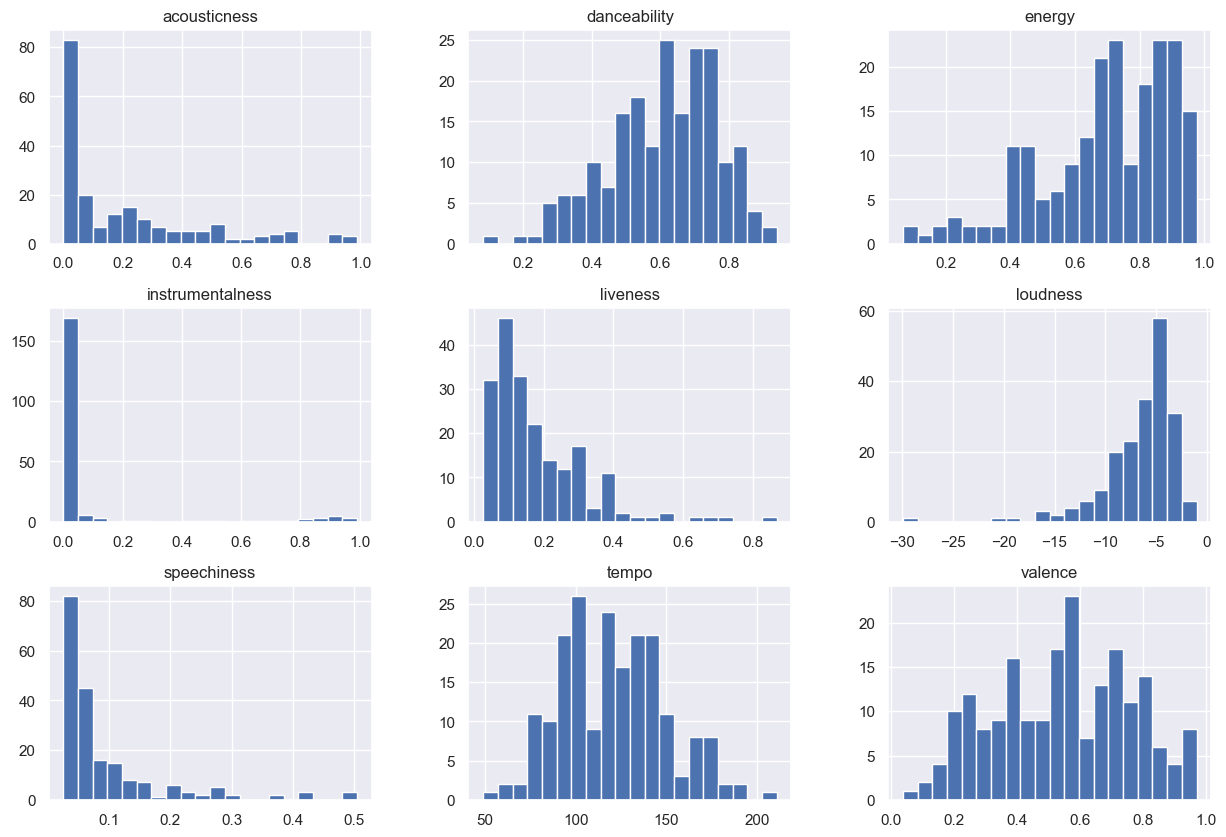

In [24]:
# Set the aesthetic style of the plots
sns.set()

# Plot histograms for numerical features
data.hist(figsize=(15, 10), bins=20)
plt.show()

# Boxplots to check for outliers
for column in data.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

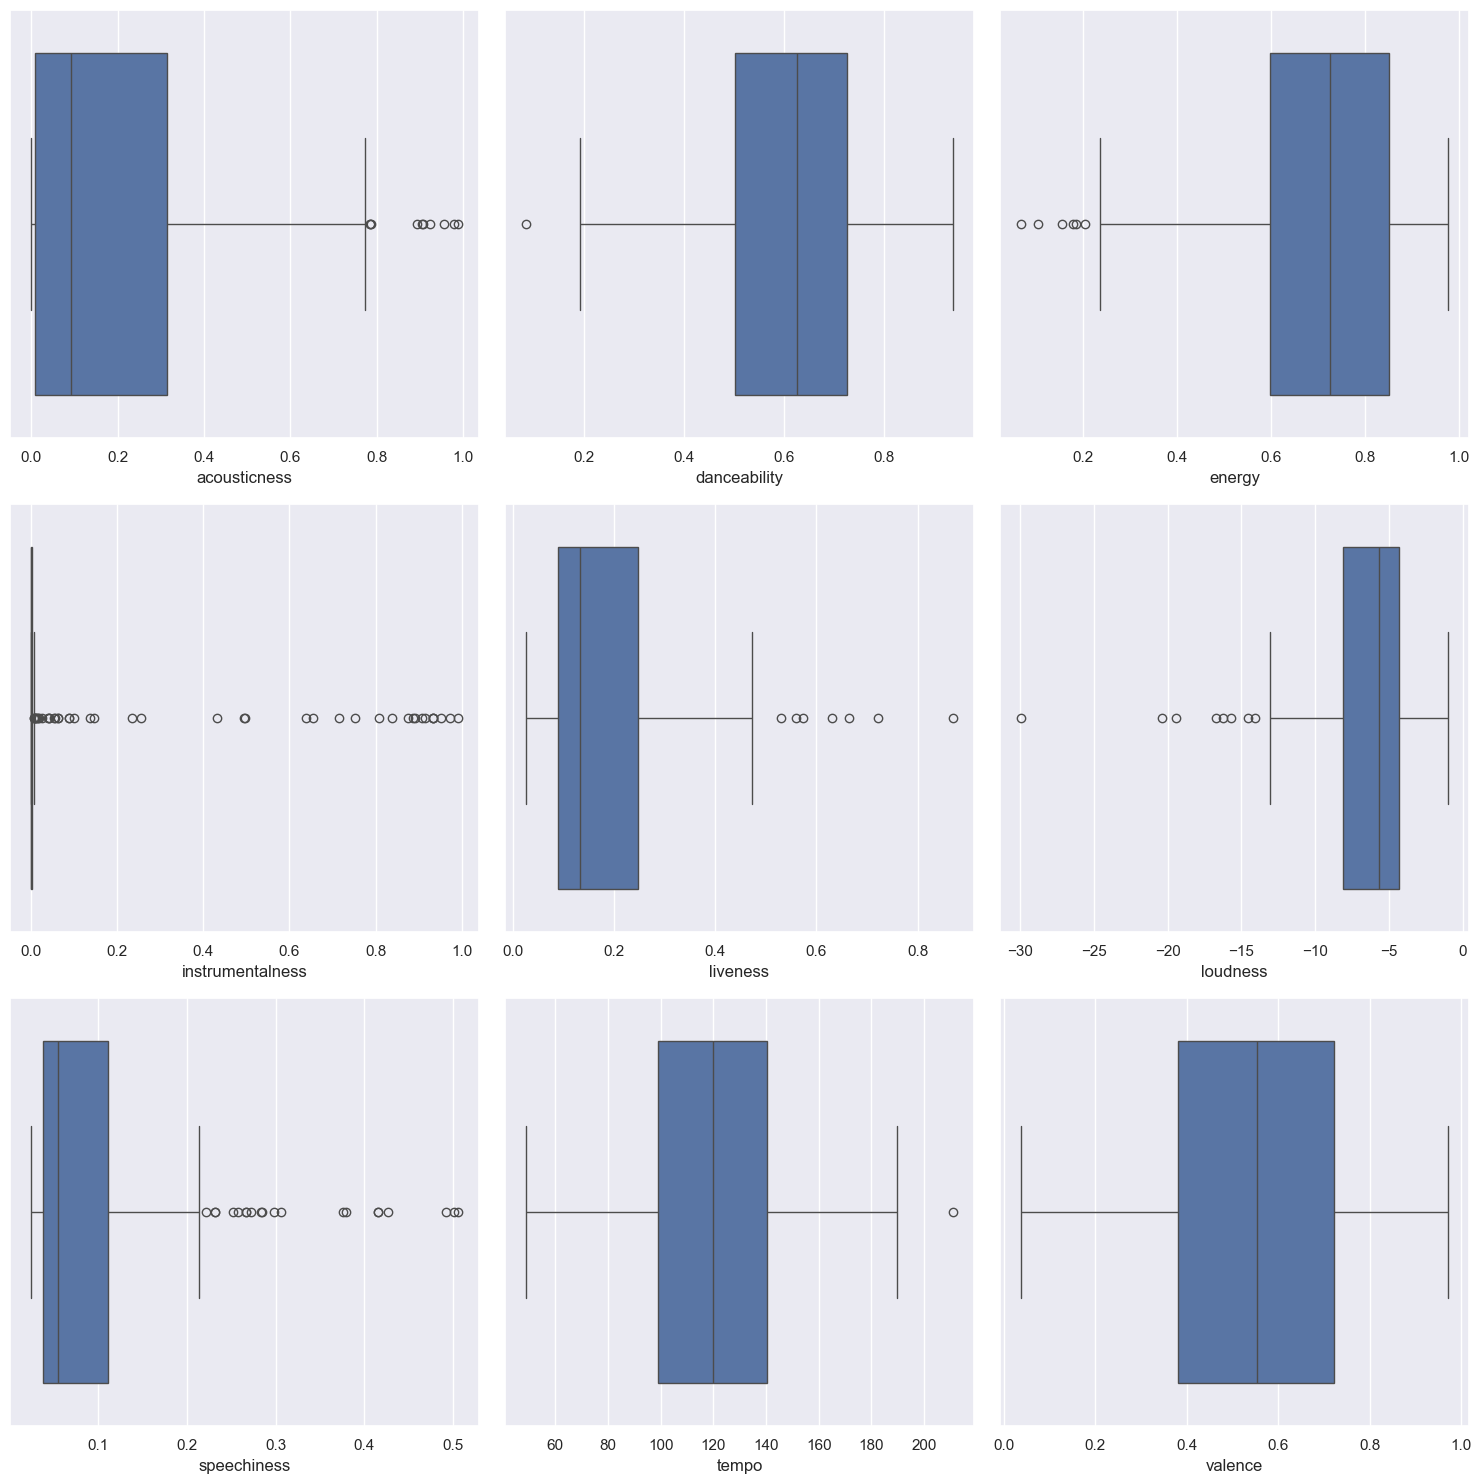

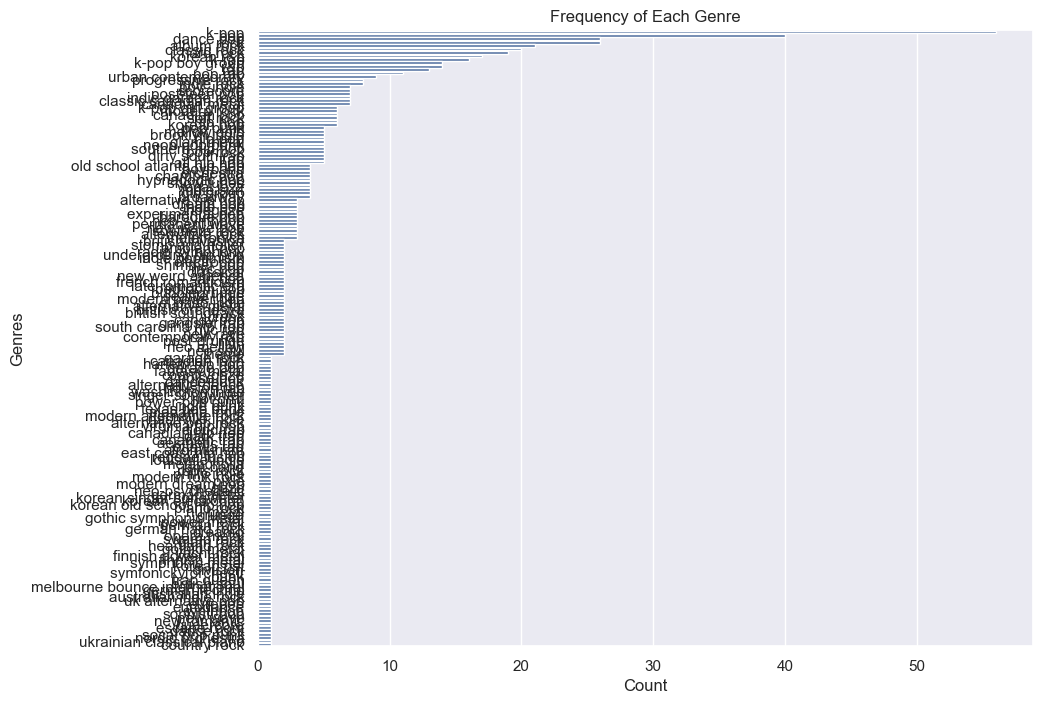

## Feature Selection

ValueError: cannot reindex on an axis with duplicate labels

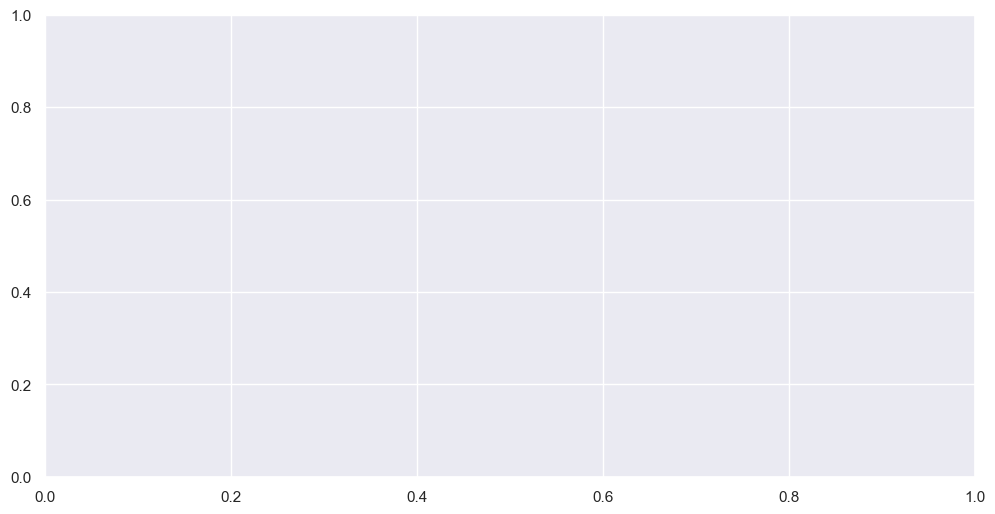

ValueError: could not convert string to float: 'The Cookbook'

<Figure size 1000x800 with 0 Axes>

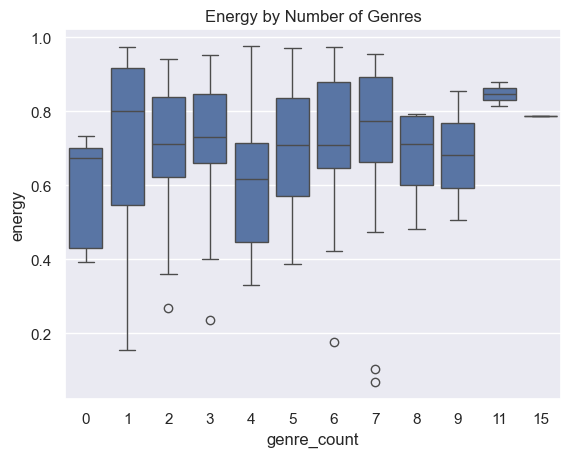

## Model Building

Building models to make predictions or understand patterns.

## Model Evaluation

## Model Optimization